In [1]:
import os
print(os.getcwd())

# data_dir = os.getcwd()+"/paper/"
# print(data_dir)

os.chdir("/Users/Jennifer/Desktop/CSE291B/actionable-recourse-git-master-repo")

# from initialize import *
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression


from examples.paper.initialize import *
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score

/Users/Jennifer/Desktop/CSE291B/actionable-recourse-git-master-repo/examples


## read in the data

In [2]:
data_name = 'german'
data_file = data_dir / ('%s_processed.csv' % data_name)
output_dir = results_dir /  data_name

## load and process data
data_df = pd.read_csv(data_file).reset_index(drop=True)
# german_df = german_df.assign(isMale=lambda df: (df['Gender']=='Male').astype(int))#.drop(['PurposeOfLoan', 'Gender', 'OtherLoansAtStore'], axis=1)
y = data_df['GoodCustomer']
X = (data_df.drop('GoodCustomer', axis=1)
#              .assign(isMale=lambda df: (df['Gender']=='Male').astype(int))
             .drop(['PurposeOfLoan', 'Gender', 'OtherLoansAtStore'], axis=1))

In [3]:
print(X.shape)
print(X.dtypes)

X.head()

(1000, 26)
ForeignWorker                      int64
Single                             int64
Age                                int64
LoanDuration                       int64
LoanAmount                         int64
LoanRateAsPercentOfIncome          int64
YearsAtCurrentHome                 int64
NumberOfOtherLoansAtBank           int64
NumberOfLiableIndividuals          int64
HasTelephone                       int64
CheckingAccountBalance_geq_0       int64
CheckingAccountBalance_geq_200     int64
SavingsAccountBalance_geq_100      int64
SavingsAccountBalance_geq_500      int64
MissedPayments                     int64
NoCurrentLoan                      int64
CriticalAccountOrLoansElsewhere    int64
OtherLoansAtBank                   int64
HasCoapplicant                     int64
HasGuarantor                       int64
OwnsHouse                          int64
RentsHouse                         int64
Unemployed                         int64
YearsAtCurrentJob_lt_1             int64
Years

,ForeignWorker,Single,Age,LoanDuration,LoanAmount,...,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled
0,0,1,67,6,1169,...,0,0,0,1,1
1,0,0,22,48,5951,...,0,0,0,0,1
2,0,1,49,12,2096,...,0,0,0,1,0
3,0,1,45,42,7882,...,0,0,0,1,1
4,0,1,53,24,4870,...,0,0,0,0,1


In [4]:
## split datasets for audit
X_clf, X_audit_holdout, y_clf, y_audit_holdout = train_test_split(X, y, test_size=0.5)

X_clf_biased = X_clf.loc[lambda df: df['Age'] >= 35] # .drop('age', axis=1)
y_clf_biased = y_clf.loc[X_clf_biased.index]

print(X_clf.shape)
print(X_audit_holdout.shape)
print(X_clf_biased.shape)

print(sum(y_audit_holdout))

## train
clf_full = (
    LogisticRegressionCV(max_iter=1000, Cs=100, cv=5)
        .fit(X_clf, # .drop('age', axis=1),
             y_clf)
)
clf_age_limited = (
    LogisticRegressionCV(max_iter=1000, Cs=100, cv=5)
        .fit(X_clf_biased, y_clf_biased)
)

(500, 26)
(500, 26)
(233, 26)
188


In [21]:
# # get dataset sizes

# X_clf, X_audit_holdout, y_clf, y_audit_holdout = train_test_split(X, y, test_size=0.5)

# X_clf_biased = X_clf.loc[lambda df: df['Age'] >= 35] # .drop('age', axis=1)
# y_clf_biased = y_clf.loc[X_clf_biased.index]

# print(X.shape)
# print(X_clf.shape)
# print(X_clf_biased.shape)
# print(X_audit_holdout.shape)

# X_clf, X_audit_holdout, y_clf, y_audit_holdout = train_test_split(X, y, test_size=0.1)

# X_clf_biased = X_clf.loc[lambda df: df['Age'] >= 35] # .drop('age', axis=1)
# y_clf_biased = y_clf.loc[X_clf_biased.index]

# print(X.shape)
# print(X_clf.shape)
# print(X_clf_biased.shape)
# print(X_audit_holdout.shape)

(1000, 26)
(500, 26)
(221, 26)
(500, 26)
(1000, 26)
(900, 26)
(404, 26)
(100, 26)


In [5]:
## split datasets for audit
X_clf, X_audit_holdout, y_clf, y_audit_holdout = train_test_split(X, y, test_size=0.5)

X_clf_biased = X_clf.loc[lambda df: df['Age'] >= 35] # .drop('age', axis=1)
y_clf_biased = y_clf.loc[X_clf_biased.index]

print(X_clf.shape)
print(X_audit_holdout.shape)
print(X_clf_biased.shape)


(500, 26)
(500, 26)
(227, 26)


## run predictions and store in a unified dataframe

In [6]:
coefficients = {}
intercept = {}
clfs = {'full': clf_full, 'downsampled': clf_age_limited}
for d in ['downsampled', 'full']:
    coefficients[d] = clfs[d].coef_[0]
    intercept[d] = clfs[d].intercept_[0]
    
print(coefficients['full'].shape)

(26,)


## run audit

In [7]:
# actionset
gender_weight = data_df.assign(c = 1).groupby('Gender')['c'].transform(lambda s: s * 1. / len(s))
X_gender_balanced = X.sample(n = len(X)*3, replace=True, weights=gender_weight)
action_set = ActionSet(X = X_gender_balanced)
action_set['Age'].mutable = False
# action_set['isMale'].mutable = False
action_set['Single'].mutable = False
action_set['JobClassIsSkilled'].mutable = False
action_set['ForeignWorker'].mutable = False
action_set['OwnsHouse'].mutable = False
action_set['RentsHouse'].mutable = False
action_set['CriticalAccountOrLoansElsewhere'].step_direction = -1
action_set['CheckingAccountBalance_geq_0'].step_direction = 1

In [8]:
# utilization bounded
# RealEstate should be positive
# numtimes90 days > 0
# monthly income >0
# debt

p = 0.98

# run audit
audit_results = {}
for dataset in ['full', 'downsampled']:
    action_set.align(coefficients=coefficients[dataset])
    
    # audit
    auditor = RecourseAuditor(
        action_set,
        coefficients = coefficients[dataset],
        intercept = intercept[dataset] - (np.log(p / (1. - p))),
    )
    audit_results[dataset] = auditor.audit(X = X_audit_holdout)

## resolve some problem with processed data max total cost

In [15]:
processed_data = {}
for training_run in ['full', 'downsampled']:
    processed_data[training_run] = (audit_results[training_run]
                .merge(X_audit_holdout['Age'], right_index=True, left_index=True)
                .merge(y_audit_holdout.to_frame('y_true'), right_index=True, left_index=True)
                .replace([np.inf, -np.inf], np.nan)
                .assign(age_cut=lambda df: pd.cut(df['Age'], np.arange(25, 80, 5)))
                .dropna()
               )

In [16]:
data = processed_data['downsampled']
for y_true in [0, 1]:
    print(data.loc[lambda df: df['y_true'] == y_true].shape)
    
data = processed_data['full']
for y_true in [0, 1]:
    print(data.loc[lambda df: df['y_true'] == y_true].shape)
    
print(processed_data['full']['cost'].max())
print(processed_data['downsampled']['cost'].max())
max_total_cost = max(processed_data['full']['cost'].max(), processed_data['downsampled']['cost'].max())
max_total_cost

print(processed_data['full']['cost'])

print(processed_data['downsampled']['cost'])

(0, 5)
(0, 5)
(0, 5)
(218, 5)
0.9255439307905529
nan
963    0.506790
262    0.408443
803    0.475948
663    0.859327
479    0.358534
         ...   
171    0.859327
365    0.218001
590    0.619999
581    0.383333
636    0.859327
Name: cost, Length: 280, dtype: float64
Series([], Name: cost, dtype: float64)


## now graph your results

0.9255439307905529
nan


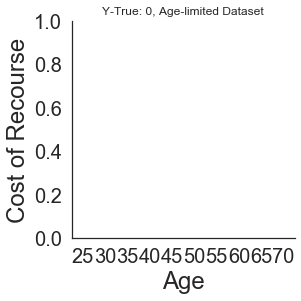

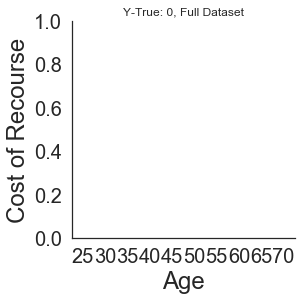

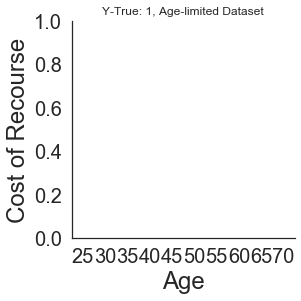

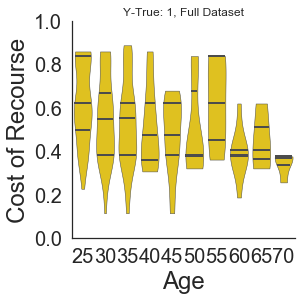

In [17]:

## plot
# max_total_cost = combined['cost'].max()
import math
if math.isnan(max(processed_data['full']['cost'].max(), processed_data['full']['cost'].max())):
    if not math.isnan(processed_data['full']['cost'].max()):
        max_total_cost = processed_data['full']['cost'].max()
    else:
        max_total_cost = processed_data['downsampled']['cost'].max()
        
print(processed_data['full']['cost'].max())
print(processed_data['downsampled']['cost'].max())

if math.isnan(max_total_cost):
    max_total_cost = 1
# assert(not math.isnan(max_total_cost))

plt.rc("font", size=20)
for y_true in [0, 1]:
    for training_run, label in [('downsampled', 'Age-limited Dataset'), ('full', 'Full Dataset')]:
        data = processed_data[training_run]       
        plt.figure(figsize=(4, 4))
        ax = sns.violinplot(
                x='age_cut', y='cost',
                data=data.loc[lambda df: df['y_true'] == y_true],
                linewidth = 0.5, cut=0,
                scale='width', color="gold",  inner='quartile'
                )
        
        ## formatting
        plt.ylim((0, 1))
        plt.ylabel("Cost of Recourse")
        plt.xlabel("Age")
        plt.title('Y-True: %s, %s' % (y_true, label))
        ax.set_ylim((0, 1))
#         ax.set_xticks(np.arange(0, 14, 2)- 1,)
        ax.set_xticklabels( np.arange(25, 80, 5))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        for l in ax.lines:
            l.set_linewidth(2.)
            l.set_linestyle('-')
            l.set_solid_capstyle('butt')
        ax.set_facecolor("white")
        plt.show()

In [12]:
## let's look at the proportion of negatives in the dataset
sum(y==-1)

300

In [13]:
sum(y_clf==-1)

149

In [14]:
sum(y_audit_holdout==-1)

151

## accuracy

In [18]:
print("\n TESTING ACCURACIES: \n")
print("total number of data points in testing set: ")
print(X_audit_holdout.shape)
predictions_baseline_test = pd.DataFrame({'y_pred': clf_full.predict(X_audit_holdout)})
predictions_baseline_test = predictions_baseline_test.merge(y_audit_holdout.to_frame('y_true'), right_index=True, left_index=True)
# print(predictions_baseline_test.loc[lambda df: df['y_true']==df['y_pred']].shape)
print("testing accuracy for baseline: ")
print(predictions_baseline_test.loc[lambda df: df['y_true']==df['y_pred']].shape[0]/X_audit_holdout.shape[0])

predictions_biased_test = pd.DataFrame({'y_pred': clf_age_limited.predict(X_audit_holdout)})
predictions_biased_test = predictions_biased_test.merge(y_audit_holdout.to_frame('y_true'), right_index=True, left_index=True)
print("testing accuracy for biased: ")
print(predictions_biased_test.loc[lambda df: df['y_true']==df['y_pred']].shape[0]/X_audit_holdout.shape[0])


print("\n TRAINING ACCURACIES: \n")
print("BASELINE")
print("total number of data points in training set: ")
print(X_clf.shape)
predictions_baseline = pd.DataFrame({'y_pred': clf_full.predict(X_clf)})
predictions_baseline = predictions_baseline.merge(y_clf.to_frame('y_true'), right_index=True, left_index=True)
print("total number of correct predictions in training set: ")
print(predictions_baseline.loc[lambda df: df['y_true']==df['y_pred']].shape)
print("training accuracy for baseline: ")
print(predictions_baseline.loc[lambda df: df['y_true']==df['y_pred']].shape[0]/X_clf.shape[0])

print("\nBIASED")
predictions_biased = pd.DataFrame({'y_pred': clf_age_limited.predict(X_clf)})
predictions_biased = predictions_biased.merge(y_clf.to_frame('y_true'), right_index=True, left_index=True)
print("total number of correct predictions in training set: ")
print(predictions_biased.loc[lambda df: df['y_true']==df['y_pred']].shape)
print("training accuracy for biased: ")
print(predictions_biased.loc[lambda df: df['y_true']==df['y_pred']].shape[0]/X_clf.shape[0])



 TESTING ACCURACIES: 

total number of data points in testing set: 
(500, 26)
testing accuracy for baseline: 
0.32
testing accuracy for biased: 
0.348

 TRAINING ACCURACIES: 

BASELINE
total number of data points in training set: 
(500, 26)
total number of correct predictions in training set: 
(170, 2)
training accuracy for baseline: 
0.34

BIASED
total number of correct predictions in training set: 
(184, 2)
training accuracy for biased: 
0.368
